In [1]:
import os
import torch
from LatentPixel import LatentGPT2, LPixelForMLM, TGraph, LPixelForClassification
from LatentPixel.training import ExpConfig
from LatentPixel import get_glue_dataset, GLUE_META
from LatentPixel import RenderConfig

_ = TGraph.init_render(dpi=180, pixels_per_patch=24)

In [2]:
GLUE_META

[('cola', ([LatentPixel.metrics.metrics.MC], 2)),
 ('sst2', ([LatentPixel.metrics.metrics.Accuracy], 2)),
 ('mrpc',
  ([LatentPixel.metrics.metrics.Accuracy, LatentPixel.metrics.metrics.F1], 2)),
 ('stsb',
  ([LatentPixel.metrics.metrics.PC, LatentPixel.metrics.metrics.SC], -1)),
 ('qqp',
  ([LatentPixel.metrics.metrics.Accuracy, LatentPixel.metrics.metrics.F1], 2)),
 ('mnli', ([LatentPixel.metrics.metrics.Accuracy], 3)),
 ('qnli', ([LatentPixel.metrics.metrics.Accuracy], 2)),
 ('rte', ([LatentPixel.metrics.metrics.Accuracy], 2)),
 ('wnli', ([LatentPixel.metrics.metrics.Accuracy], 2))]

In [3]:
config = ExpConfig()
config

ExpConfig(model='LPixelForMLM', init_path='', backbone_path='', coder_path='', render_path='storage/pixel-base', checkpoint_path='storage/checkpoints', dataset_paths=[''], seed=42, exp_type='debug', task='lpixel_pretrain', stage=1, optim='AdamW', scheduler='CosineAnnealingLR', batch_size=256, sub_size=128, eval_batch_size=256, eval_num_batch=12, lr=1e-05, beta1=0.9, beta2=0.95, decay=0.01, momentum=0.95, clip=1.0, mask_ratio=0.25, mask_type='span', total_steps=4000, max_token=512, eval_freq=100, save_freq=1000, best_save_freq=100, test_gpu_usibility=False, dpi=120, font_size=8, pad_size=3, pixels_per_patch=16, compress_ratio=8, font_file='GoNotoCurrent.ttf', image_size=[3, 16, 8464], latent_size=[3, 16, 8464], torch_compile=False, dynamic_shape=False, mix_precision='no', half_precision=False, half_coder=False, gradient_checkpointing=False, num_gpu_per_node=1, num_node=2, mp_workers=4, shard_strategy='no', offload_to_cpu=False, backward_prefetch='pre', on_cpu=False, current_step=1, num_

In [5]:
train_loader, dev_loaders, metrics, num_labels = get_glue_dataset('mnli', sub_size=4, mp_workers=4, seed=42, render_config=RenderConfig(dpi=180, pixels_per_patch=24))

Found cached dataset glue (/home/sc118/sc118/yintaotai/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Found cached dataset glue (/home/sc118/sc118/yintaotai/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
Found cached dataset glue (/home/sc118/sc118/yintaotai/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [6]:
tb = next(iter(dev_loaders[0]))
num_labels

pid 1159225's current affinity mask: 1000000001
pid 1159225's new affinity mask: ffffffffff
pid 1159278's current affinity mask: 1000000001
pid 1159278's new affinity mask: ffffffffff
pid 1159162's current affinity mask: 1000000001
pid 1159162's new affinity mask: ffffffffff
pid 1159228's current affinity mask: 1000000001
pid 1159228's new affinity mask: ffffffffff


3

In [8]:
model = LPixelForClassification(
    coder_path='storage/SD2_VQGAN',
    backbone_path='storage/checkpoints/HL_pixel_2/lpixel_pretrain/LPixelForMLM/20230801-164748/100000/backbone',
    img_size=[3, 24, 12696],
    latent_size=[4, 3, 12696 // 8],
    num_labels=num_labels
)
model.delete_unused_layers()

loading the coder from storage/SD2_VQGAN


Some weights of the model checkpoint at storage/checkpoints/HL_pixel_2/lpixel_pretrain/LPixelForMLM/20230801-164748/100000/backbone were not used when initializing PIXELForSequenceClassification: ['decoder.decoder_layers.7.attention.output.dense.bias', 'decoder.decoder_layers.4.layernorm_after.weight', 'decoder.decoder_layers.3.attention.output.dense.weight', 'decoder.decoder_layers.4.layernorm_before.weight', 'decoder.decoder_layers.5.attention.output.dense.bias', 'decoder.decoder_layers.1.attention.output.dense.weight', 'decoder.decoder_layers.4.layernorm_before.bias', 'decoder.decoder_layers.4.attention.attention.value.bias', 'decoder.decoder_layers.3.layernorm_before.bias', 'decoder.decoder_layers.3.intermediate.dense.weight', 'decoder.decoder_layers.7.output.dense.bias', 'decoder.decoder_layers.7.attention.attention.key.weight', 'decoder.decoder_layers.1.intermediate.dense.bias', 'decoder.decoder_layers.5.layernorm_before.bias', 'decoder.decoder_layers.6.attention.attention.key.we

delete the decoder
The decoder of the coder is deleted


In [28]:
tb._value.shape

torch.Size([4, 3, 24, 12696])

In [36]:
model.delete_unused_layers()

The decoder of the coder is deleted


In [9]:
with torch.no_grad():
    result = model(tb)

/work/sc118/sc118/yintaotai/miniconda3/envs/pt2hfpy310/lib/python3.10/site-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [10]:
result.loss

tensor(1.0831)

In [14]:
result.value

tensor([[-0.3468, -0.8664, -0.2123],
        [-0.2795, -0.8263, -0.2373],
        [-0.3301, -0.8646, -0.1751],
        [-0.2990, -0.8279, -0.1640]])

In [15]:
result.predcits

tensor([2, 2, 2, 2])

In [17]:
gpt = LatentGPT2(coder_path='storage/SD2_VQGAN/', backbone_path='storage/checkpoints/HL_gpt2_1/lpixel_pretrain/LatentGPT2/20230728-024648/2000/backbone', img_size=[3, 24, 24*529], latent_size=[4, 3, 3*529])
# gpt.init_connection_layers()

loading the coder from storage/SD2_VQGAN/


In [20]:
gpt.backbone.wte

Embedding(50257, 768)

In [4]:
tg = TGraph.from_text(['this is a sentence' * 10, 'this is another sentence'])
tg.init_patch_mask('rand')
# r: TGraph = pixel(tg)

tensor([[1, 0, 0,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 1, 1, 0]], dtype=torch.int32)

In [12]:
tg.labels = torch.tensor([1, 1])
r = pixel(tg)

/work/sc118/sc118/yintaotai/miniconda3/envs/pt2hfpy310/lib/python3.10/site-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [13]:
r.loss

tensor(1.7561, grad_fn=<NllLossBackward0>)

In [5]:
gpt.delete_unused_layers()

delete the decoder


In [6]:
r = gpt(tg)

loss torch.Size([2, 4, 4, 2116])
attention_mask torch.Size([2, 1, 4, 2116])


In [10]:
r._value.min()

tensor(-91.8794, grad_fn=<MinBackward1>)

In [24]:
latent.attention_mask.shape

torch.Size([2, 529])

In [28]:
pixel.backbone.config.problem_type

'single_label_classification'

In [25]:
result = pixel.backbone.forward(pixel_values=latent._value, attention_mask=tg.attention_mask, labels=torch.tensor([[1, 2]]))

/work/sc118/sc118/yintaotai/miniconda3/envs/pt2hfpy310/lib/python3.10/site-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [26]:
result.logits.argmax(-1)

tensor([1, 1])

In [27]:
result.loss

tensor(1.2557, grad_fn=<NllLossBackward0>)

In [3]:
tg = TGraph.from_text(['this is a sentence' * 10])
tg.init_patch_mask('rand')
r: TGraph = gpt(tg)

loss torch.Size([1, 4, 4, 2116])
attention_mask torch.Size([4, 2116])


In [7]:
gpt.load_coder('testgptc')

loading the coder from testgptc


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [6]:
r.value.shape

torch.Size([1, 3, 32, 16928])

In [4]:
gpt.backbone.in_proj

Conv2d(4, 768, kernel_size=(4, 4), stride=(4, 4), bias=False)

In [5]:
gpt.backbone.out_proj

ConvTranspose2d(768, 4, kernel_size=(4, 4), stride=(4, 4), bias=False)

In [6]:
gpt.backbone.out_proj

ConvTranspose2d(768, 4, kernel_size=(4, 4), stride=(4, 4), bias=False)

In [37]:
test = torch.randn([2, 4, 4, 4*529])
test[0, :, :, 4*528:] = 0

In [38]:
test1 = gpt.backbone.in_proj(test).flatten(2).transpose(1, 2)

In [39]:
test1.shape

torch.Size([2, 529, 768])

In [40]:
test1[0, 528]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [41]:
test2 = test1.transpose(1, 2).unsqueeze(2)
test2.shape

torch.Size([2, 768, 1, 529])

In [43]:
test3 = gpt.backbone.out_proj(test2)

In [44]:
test3.shape

torch.Size([2, 4, 4, 2116])

In [52]:
test3[0, 2, :, 4*527:]

tensor([[-1.5434, -2.0241, -0.2671, -0.0388,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1755,  0.5449,  0.4494, -0.6084,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.7187,  0.1441,  0.4418, -0.7696,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.2200,  2.1017, -1.5394, -1.2013,  0.0000,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SliceBackward0>)

In [8]:
from datasets import load_dataset

In [12]:
data = load_dataset('glue', 'sst2')

Found cached dataset glue (/work/sc118/sc118/yintaotai/huggingface_cache/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
min(data['train']['label'])

0

In [53]:
from sklearn.feature_selection import r_regression
from sklearn.isotonic import check_increasing
from scipy.stats import spearmanr


In [36]:
x = torch.randn([25])
y = torch.randn([25])

In [37]:
r_regression(y.unsqueeze(1), x)

array([-0.35900236])

In [38]:
check_increasing(x, y)

/work/sc118/sc118/yintaotai/miniconda3/envs/pt2hfpy310/lib/python3.10/site-packages/sklearn/isotonic.py:72: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn(


False

In [41]:
z = torch.cat([x, y], 1)
torch.corrcoef(x, y)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [52]:
z = torch.cat([x.unsqueeze(0), x.unsqueeze(0)], 0)
torch.corrcoef(z)

tensor([[1., 1.],
        [1., 1.]])

In [61]:
z

tensor([[ 1.0737,  0.2292, -0.7755, -1.1825, -0.2974,  0.7446, -0.5225,  0.4524,
          0.8721, -0.4253,  0.4445,  0.7918,  0.9407,  0.7764, -0.5844, -1.0665,
          0.8239,  0.9631, -1.7365, -0.8120, -0.1938, -0.6648, -0.5479,  0.0563,
          0.0155],
        [ 1.0737,  0.2292, -0.7755, -1.1825, -0.2974,  0.7446, -0.5225,  0.4524,
          0.8721, -0.4253,  0.4445,  0.7918,  0.9407,  0.7764, -0.5844, -1.0665,
          0.8239,  0.9631, -1.7365, -0.8120, -0.1938, -0.6648, -0.5479,  0.0563,
          0.0155]])

In [51]:
x

tensor([ 1.0737,  0.2292, -0.7755, -1.1825, -0.2974,  0.7446, -0.5225,  0.4524,
         0.8721, -0.4253,  0.4445,  0.7918,  0.9407,  0.7764, -0.5844, -1.0665,
         0.8239,  0.9631, -1.7365, -0.8120, -0.1938, -0.6648, -0.5479,  0.0563,
         0.0155])

In [60]:
spearmanr(x.tolist(), y.tolist()).statistic

-0.2792307692307692

In [33]:
a = torch.randn([6, 4, 3, 1587])
b = torch.randn([6, 3, 1587]).unsqueeze(1)

In [34]:
a * b

tensor([[[[ 1.5463e-01, -5.1946e-01,  8.3427e-01,  ..., -3.4802e-02,
           -4.8067e-01, -7.7102e-01],
          [ 8.2560e-02, -4.2176e-02,  9.2452e-03,  ..., -1.1269e-01,
            2.3402e-02,  5.5810e-01],
          [-3.3604e-01,  6.0198e-01, -1.9294e-02,  ..., -4.7259e-01,
            5.4446e-01,  4.8747e-02]],

         [[ 1.0295e-01, -2.1744e+00, -3.6195e-01,  ..., -1.5480e-02,
           -4.7069e-02, -1.1261e+00],
          [ 1.8461e-01,  1.1367e+00, -1.0771e-02,  ..., -2.8918e-01,
           -1.4733e+00,  1.7462e-01],
          [-1.4952e+00,  3.9007e-01, -7.8901e-02,  ...,  6.1379e-01,
           -1.7326e+00, -8.1790e-02]],

         [[-1.4182e-01, -2.4000e-01, -1.3953e-01,  ..., -4.7799e-02,
            7.3503e-01,  2.2638e+00],
          [-1.0469e-01,  8.0707e-01,  1.0392e-02,  ...,  3.1664e-01,
           -2.6168e-01, -9.5351e-01],
          [-1.2184e-01, -1.0882e+00,  6.7330e-02,  ...,  3.5869e-01,
            3.4718e+00,  5.0007e-02]],

         [[-1.5519e-02,  1.6251

In [1]:
from datasets import load_dataset, interleave_datasets, load_from_disk
from datasets.distributed import split_dataset_by_node
from collections import defaultdict

from LatentPixel import TGraph, RenderConfig, get_glue_dataset
import torch
from torch.utils.data import DataLoader
import os


In [122]:
def collate_glue(batch: dict) -> TGraph:
    merged = defaultdict(list)
    for sample in batch:
        for k, v in sample.items():
            merged[k].append(v)
    batch = merged
    label = batch['label']
    if len(batch) == 4:
        keys = list(batch.keys())
        text = list(zip(batch[keys[0]], batch[keys[1]]))
    elif len(batch) == 3:
        key = list(batch.keys())[0]
        text = batch[key]
    else:
        raise ValueError(f'GLUE dataset should be 3 or 4 fields, but got {len(batch)} fields')
    
    tgraph = TGraph.from_text(text)
    tgraph.labels = torch.tensor(label)
    assert isinstance(tgraph.labels, torch.LongTensor) or isinstance(tgraph.labels, torch.DoubleTensor)
    tgraph.attention_mask   # init the attention mask
    
    return tgraph


In [135]:
data = load_dataset('glue', 'cola', split='train')
data = split_dataset_by_node(data, 0, 16)

Found cached dataset glue (/home/sc118/sc118/yintaotai/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


In [136]:
len(data)

535

In [2]:
a

NameError: name 'a' is not defined

In [126]:
loader = DataLoader(data, batch_size=8, collate_fn=collate_glue, num_workers=4)

In [127]:
batch = next(iter(loader))

[1, 0, 0, 0, 1, 1, 0, 1]
[1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1][1, 1, 1, 1, 1, 1, 1, 1][1, 1, 1, 1, 1, 1, 1, 1]




In [129]:
batch.labels.dtype

torch.int64

In [68]:
len(batch)

4

In [51]:
b = TGraph.from_text(list(zip(batch[list(batch.keys())[0]], batch[list(batch.keys())[1]])))

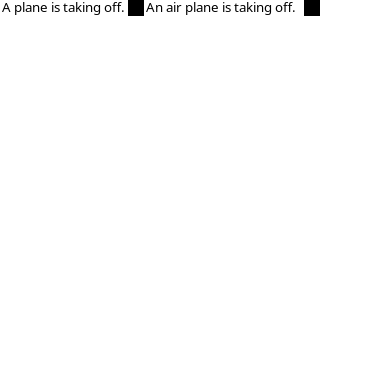

In [67]:
b.squarelize().to_PIL()[0]

In [63]:
b.attention_mask[0].sum()

tensor(20.)

In [65]:
23*23

529

In [3]:
rconfig = RenderConfig()
render = TGraph.init_render(**rconfig.to_dict())

In [4]:
type(render)

pixel.data.rendering.pangocairo_renderer.PangoCairoTextRenderer

In [8]:
t = TGraph.from_text([('this is a sentecne', 'another one'), ('this is a sentecne', 'another one')])

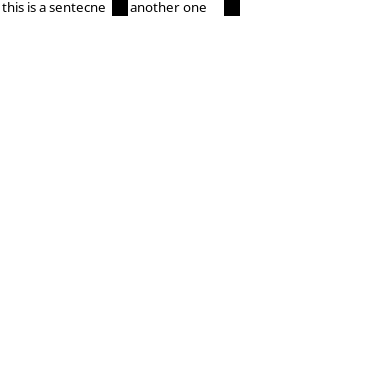

In [11]:
t.squarelize().to_PIL()[1]

In [21]:
a.pixel_values.shape

(16, 8464, 3)

In [22]:
import matplotlib.pyplot as plt

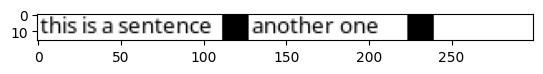

In [26]:
plt.imshow(a.pixel_values[:, :300, :])